<a href="https://colab.research.google.com/github/CarlosModinez/brazilian_weeds/blob/main/weed_species_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os

from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Dataset organizer

Don't run it if your dataset is structured

In [18]:
import shutil

DATASET_PATH = "drive/My Drive/TCC/brazilian_weeds_2020"
families = os.listdir(DATASET_PATH)

def get_species():
  species = []
  for family in families:
    if os.path.isdir(os.path.join(DATASET_PATH, family)):
      species.extend(os.listdir(os.path.join(DATASET_PATH, family)))
  return species

classes = get_species()

In [19]:
def search_images(path, image_paths=[]):
    image_extensions = ['jpg', 'jpeg']

    if os.path.exists(path) and os.path.isdir(path):
        for file in os.listdir(path):
            file_extension = file.split(".")[-1].lower()
            if file_extension in image_extensions:
                  image_paths.append(os.path.join(path, file))
            elif os.path.isdir(os.path.join(path, file)):
                search_images(os.path.join(path, file), image_paths)
    return image_paths

def get_class(image_path, classes):
  for plant_class in classes:
    if plant_class.lower() in image_path.lower():
      return plant_class
  return None

def build_dataset(dataset_path, classes):
  image_paths = search_images(dataset_path)

  for image_path in image_paths:
    label = get_class(image_path, classes)
    destination_path = "drive/My Drive/TCC/brazil_weeds_2020_species_classification/" + label + "/"

    if not os.path.exists(destination_path):
      os.makedirs(destination_path)

    shutil.copy(image_path, destination_path)

build_dataset(DATASET_PATH, classes)

## Classifier

In [3]:
DATASET_PATH = "drive/My Drive/TCC/brazil_weeds_2020_species_classification"
os.listdir(DATASET_PATH)

['Tridax procumbens',
 'Sonchus oleraceus',
 'Bidens-pilosa',
 'Leonurus sibiricus',
 'Digitaria insularis',
 'Rhynchelytrumrepens',
 'Cenchus echinatus',
 'Choris barbata',
 'Sorghum arundinaceum',
 'Physalis angulata',
 'Amaranthus hybridos',
 'Ipomoeae purpurea',
 'Cyclospermum leptophyllum',
 'Lelidium virginum']

In [4]:
img_height = 1024
img_width = 1024
batch_size = 32

full_ds = tf.keras.utils.image_dataset_from_directory(
  DATASET_PATH,
  image_size=(img_width, img_height),
  batch_size=batch_size,
  shuffle=True,
  seed=123  # Set seed for reproducibility
)

total_samples = len(full_ds)
train_size = int(0.7 * total_samples)
val_size = int(0.15 * total_samples)
test_size = total_samples - train_size - val_size

train_ds = full_ds.take(train_size)
remaining_ds = full_ds.skip(train_size)
val_ds = remaining_ds.take(val_size)
test_ds = remaining_ds.skip(val_size)

Found 787 files belonging to 14 classes.


In [5]:
class_names = full_ds.class_names
class_names

['Amaranthus hybridos',
 'Bidens-pilosa',
 'Cenchus echinatus',
 'Choris barbata',
 'Cyclospermum leptophyllum',
 'Digitaria insularis',
 'Ipomoeae purpurea',
 'Lelidium virginum',
 'Leonurus sibiricus',
 'Physalis angulata',
 'Rhynchelytrumrepens',
 'Sonchus oleraceus',
 'Sorghum arundinaceum',
 'Tridax procumbens']

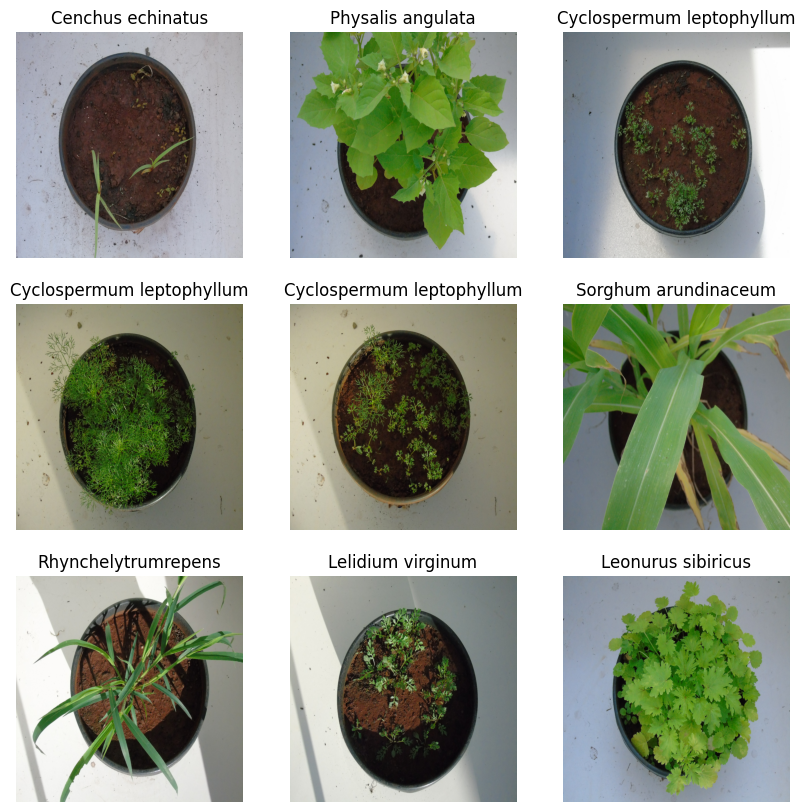

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x),y))
image_batch, labels_batch = next(iter(normalized_ds))

In [7]:
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal", input_shape=(img_width,img_height,3)),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.1),
  layers.RandomContrast(0.1),
])

In [8]:
class FocalLoss(tf.keras.losses.Loss):
  def __init__(self, alpha=0.25, gamma=2.0, **kwargs):
    self.alpha = alpha
    self.gamma = gamma
    super(FocalLoss, self).__init__(**kwargs)

  def call(self, y_true, y_pred):
    ce_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=True)
    pt = tf.math.exp(-ce_loss)
    focal_loss = self.alpha * tf.math.pow(1.0 - pt, self.gamma) * ce_loss
    return focal_loss

## Fine-tune models

*  VGG19
*  ResNet152
*  ResNet50
*  ResNet101
*  MobileNetV3
*  MobileNetV2


In [9]:
from tensorflow.keras.applications import VGG19, ResNet152, ResNet50, ResNet101, MobileNetV3Large, MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

import seaborn as sns

epochs = 20
num_classes = len(class_names)

train_labels = np.array([])
for images, labels in train_ds.take(len(train_ds)):
  train_labels = np.concatenate((train_labels, labels.numpy()), axis=0)

class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)

In [10]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal", input_shape=(224, 224, 3)),
  tf.keras.layers.RandomRotation(0.1),
  tf.keras.layers.RandomZoom(0.1),
  tf.keras.layers.RandomContrast(0.1),
])

resize_layer = tf.keras.layers.Resizing(224, 224)

def preprocess_image(image, label):
    image = normalization_layer(image)
    image = resize_layer(image)
    image = data_augmentation(image)
    return image, label

def resize_image(image, label):
  image = normalization_layer(image)
  image = resize_layer(image)
  return image, label

augmented_train_ds = train_ds.map(preprocess_image)
resized_val_ds = val_ds.map(resize_image)
resized_test_ds = test_ds.map(resize_image)

In [11]:
def fine_tune_model(base_model, loss='focal_loss', class_weights=None, train_ds=None, val_ds=None, epochs=30):
  for layer in base_model.layers:
    layer.trainable = False

  x = base_model.output
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(1024, activation='relu')(x)
  predictions = layers.Dense(num_classes)(x)

  model = Model(inputs=base_model.input, outputs=predictions)
  if loss == 'focal_loss':
    model.compile(optimizer='adam', loss=FocalLoss(), metrics=['accuracy'])
  else:
    model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'], loss_weights=class_weights)

  history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

  return model, history


def evaluate_model(model, test_ds, class_names, ax):
  predictions = model.predict(test_ds)
  predicted_labels = np.argmax(predictions, axis=1)
  true_labels = np.concatenate([y for x, y in test_ds], axis=0)

  conf_matrix = confusion_matrix(true_labels, predicted_labels, normalize='true')

  sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax)
  plt.xlabel('Predicted')
  plt.ylabel('True')

  report = classification_report(true_labels, predicted_labels, target_names=class_names)

  return report


def generate_fc_wce_comparison(fc_model, wce_model, test_ds, class_names):
  print("evaluating with test data")
  fig, axs = plt.subplots(1,2,figsize=(16, 8))

  report_fc = evaluate_model(fc_model, test_ds, class_names, axs[0])
  report_wce = evaluate_model(wce_model, test_ds, class_names, axs[1])

  axs[0].set_title('Confusion matrix - Focal loss')
  axs[1].set_title('Confusion matrix - Weighted cross entropy')

  return fig, report_fc, report_wce

def build_focal_weighted_loss_comparision(base_model, train_ds, val_ds, epochs):
  print("Training with focal loss")
  model_fc, history_fc = fine_tune_model(base_model, train_ds=train_ds, val_ds=val_ds, epochs=epochs) # focal loss

  print("Training with weighted cross entropy")
  model_wce, history_wce = fine_tune_model(base_model, train_ds=train_ds, loss='weighted', class_weights=class_weights, val_ds=val_ds, epochs=epochs) # weighted-cross-entropy

  return model_fc, history_fc, model_wce, history_wce

### VGG19

80134624/80134624 [==============================] - 4s 0us/step
Epoch 1/20
17/17 [==============================] - 47s 3s/step - loss: 0.5558 - accuracy: 0.1158 - val_loss: 0.4782 - val_accuracy: 0.2083
Epoch 2/20
17/17 [==============================] - 11s 659ms/step - loss: 0.4192 - accuracy: 0.3585 - val_loss: 0.4195 - val_accuracy: 0.3229
Epoch 3/20
17/17 [==============================] - 11s 639ms/step - loss: 0.3486 - accuracy: 0.3989 - val_loss: 0.3520 - val_accuracy: 0.3542
Epoch 4/20
17/17 [==============================] - 11s 639ms/step - loss: 0.3138 - accuracy: 0.4246 - val_loss: 0.3505 - val_accuracy: 0.3646
Epoch 5/20
17/17 [==============================] - 11s 640ms/step - loss: 0.2659 - accuracy: 0.5092 - val_loss: 0.2969 - val_accuracy: 0.3958
Epoch 6/20
17/17 [==============================] - 11s 638ms/step - loss: 0.2403 - accuracy: 0.5257 - val_loss: 0.2479 - val_accuracy: 0.5208
Epoch 7/20
17/17 [==============================] - 11s 639ms/step - loss: 0.210

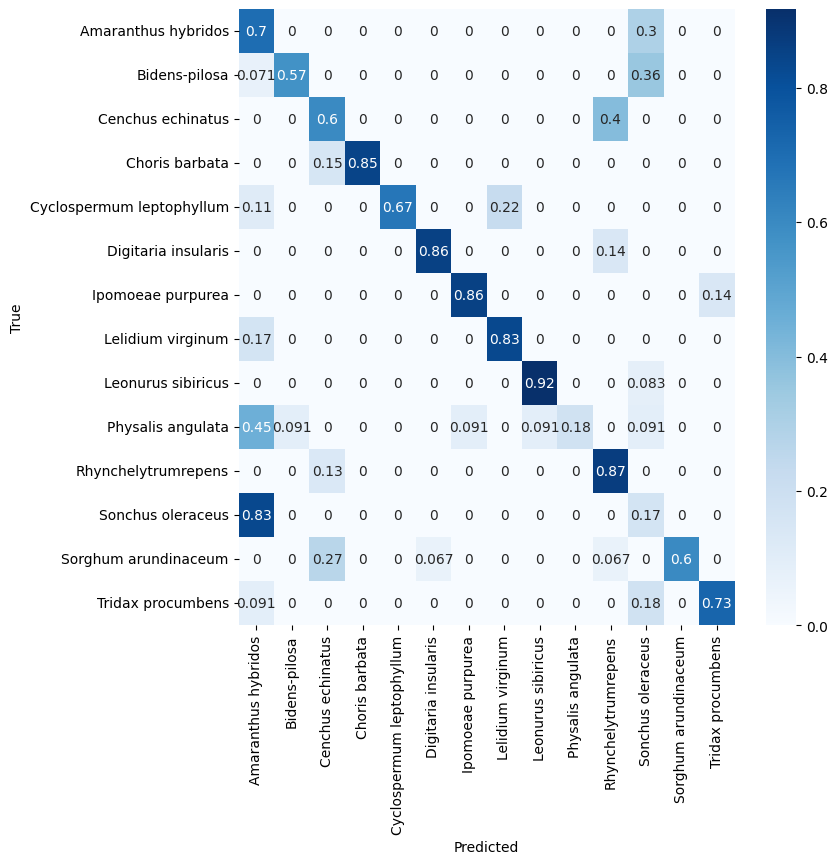

                           precision    recall  f1-score   support

      Amaranthus hybridos       0.32      0.70      0.44        10
            Bidens-pilosa       0.89      0.57      0.70        14
        Cenchus echinatus       0.27      0.60      0.37         5
           Choris barbata       1.00      0.85      0.92        13
Cyclospermum leptophyllum       1.00      0.67      0.80         9
      Digitaria insularis       0.86      0.86      0.86         7
        Ipomoeae purpurea       0.86      0.86      0.86         7
        Lelidium virginum       0.83      0.83      0.83        12
       Leonurus sibiricus       0.92      0.92      0.92        12
        Physalis angulata       1.00      0.18      0.31        11
      Rhynchelytrumrepens       0.76      0.87      0.81        15
        Sonchus oleraceus       0.08      0.17      0.11         6
     Sorghum arundinaceum       1.00      0.60      0.75        15
        Tridax procumbens       0.89      0.73      0.80     

In [12]:
vgg19_model = VGG19(weights='imagenet', include_top=False)

for layer in vgg19_model.layers:
  layer.trainable = False

x = vgg19_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
predictions = layers.Dense(num_classes)(x)

model = Model(inputs=vgg19_model.input, outputs=predictions)

model.compile(optimizer='adam', loss=FocalLoss(), metrics=['accuracy'])
model.fit(augmented_train_ds, validation_data=resized_val_ds, epochs=epochs)

predictions = model.predict(resized_test_ds)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.concatenate([y for x, y in resized_test_ds], axis=0)

conf_matrix = confusion_matrix(true_labels, predicted_labels, normalize='true')

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(classification_report(true_labels, predicted_labels, target_names=class_names))

Epoch 1/20
17/17 [==============================] - 12s 654ms/step - loss: 0.9144 - accuracy: 0.7169 - val_loss: 0.9605 - val_accuracy: 0.6667
Epoch 2/20
17/17 [==============================] - 11s 652ms/step - loss: 0.8107 - accuracy: 0.7500 - val_loss: 0.9553 - val_accuracy: 0.6458
Epoch 3/20
17/17 [==============================] - 11s 660ms/step - loss: 0.7807 - accuracy: 0.7831 - val_loss: 0.9293 - val_accuracy: 0.6875
Epoch 4/20
17/17 [==============================] - 11s 649ms/step - loss: 0.8277 - accuracy: 0.7408 - val_loss: 0.9320 - val_accuracy: 0.6458
Epoch 5/20
17/17 [==============================] - 11s 655ms/step - loss: 0.7727 - accuracy: 0.7757 - val_loss: 0.8961 - val_accuracy: 0.6562
Epoch 6/20
17/17 [==============================] - 11s 650ms/step - loss: 0.7350 - accuracy: 0.7721 - val_loss: 0.8703 - val_accuracy: 0.6875
Epoch 7/20
17/17 [==============================] - 11s 650ms/step - loss: 0.7104 - accuracy: 0.7721 - val_loss: 0.9121 - val_accuracy: 0.6667

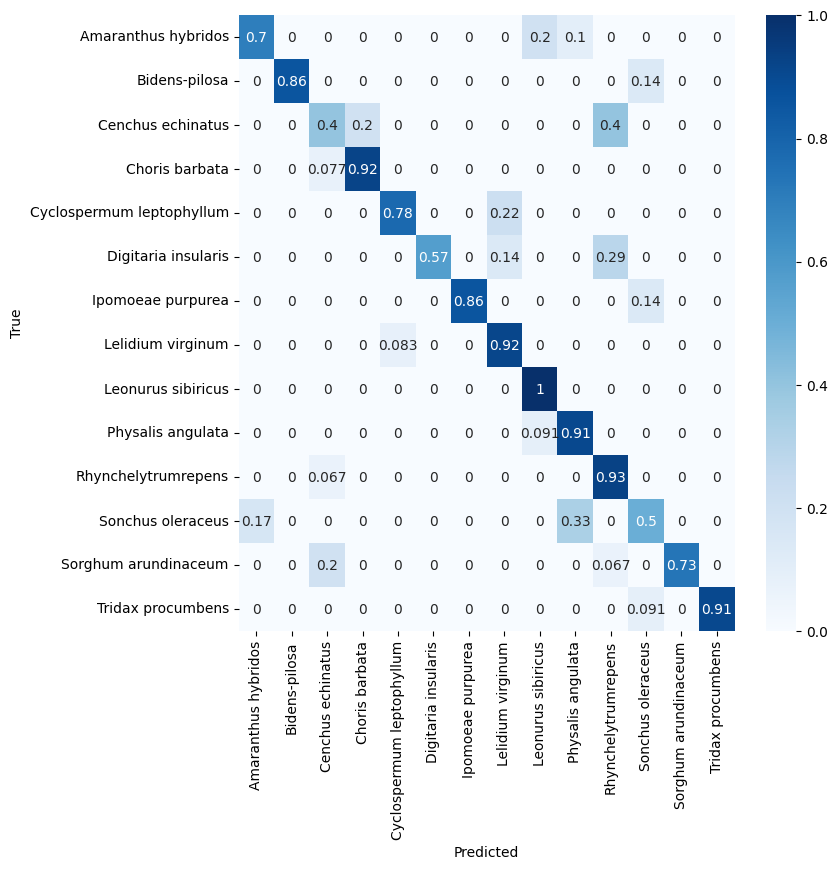

                           precision    recall  f1-score   support

      Amaranthus hybridos       0.88      0.70      0.78        10
            Bidens-pilosa       1.00      0.86      0.92        14
        Cenchus echinatus       0.29      0.40      0.33         5
           Choris barbata       0.92      0.92      0.92        13
Cyclospermum leptophyllum       0.88      0.78      0.82         9
      Digitaria insularis       1.00      0.57      0.73         7
        Ipomoeae purpurea       1.00      0.86      0.92         7
        Lelidium virginum       0.79      0.92      0.85        12
       Leonurus sibiricus       0.80      1.00      0.89        12
        Physalis angulata       0.77      0.91      0.83        11
      Rhynchelytrumrepens       0.74      0.93      0.82        15
        Sonchus oleraceus       0.43      0.50      0.46         6
     Sorghum arundinaceum       1.00      0.73      0.85        15
        Tridax procumbens       1.00      0.91      0.95     

In [13]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'],
  loss_weights=class_weights
)

model.fit(augmented_train_ds, validation_data=resized_val_ds, epochs=epochs)

predictions = model.predict(resized_test_ds)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.concatenate([y for x, y in resized_test_ds], axis=0)

conf_matrix = confusion_matrix(true_labels, predicted_labels, normalize='true')

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(classification_report(true_labels, predicted_labels, target_names=class_names))


### ResNet152

234698864/234698864 [==============================] - 10s 0us/step
Training with focal loss
Epoch 1/20
17/17 [==============================] - 43s 2s/step - loss: 0.5620 - accuracy: 0.3438 - val_loss: 0.2396 - val_accuracy: 0.5312
Epoch 2/20
17/17 [==============================] - 25s 1s/step - loss: 0.1432 - accuracy: 0.7316 - val_loss: 0.1171 - val_accuracy: 0.7812
Epoch 3/20
17/17 [==============================] - 25s 1s/step - loss: 0.0765 - accuracy: 0.8603 - val_loss: 0.0935 - val_accuracy: 0.8646
Epoch 4/20
17/17 [==============================] - 25s 1s/step - loss: 0.0507 - accuracy: 0.9062 - val_loss: 0.0562 - val_accuracy: 0.8958
Epoch 5/20
17/17 [==============================] - 25s 1s/step - loss: 0.0504 - accuracy: 0.8952 - val_loss: 0.0372 - val_accuracy: 0.9479
Epoch 6/20
17/17 [==============================] - 25s 1s/step - loss: 0.0273 - accuracy: 0.9540 - val_loss: 0.0313 - val_accuracy: 0.9583
Epoch 7/20
17/17 [==============================] - 25s 1s/step - l

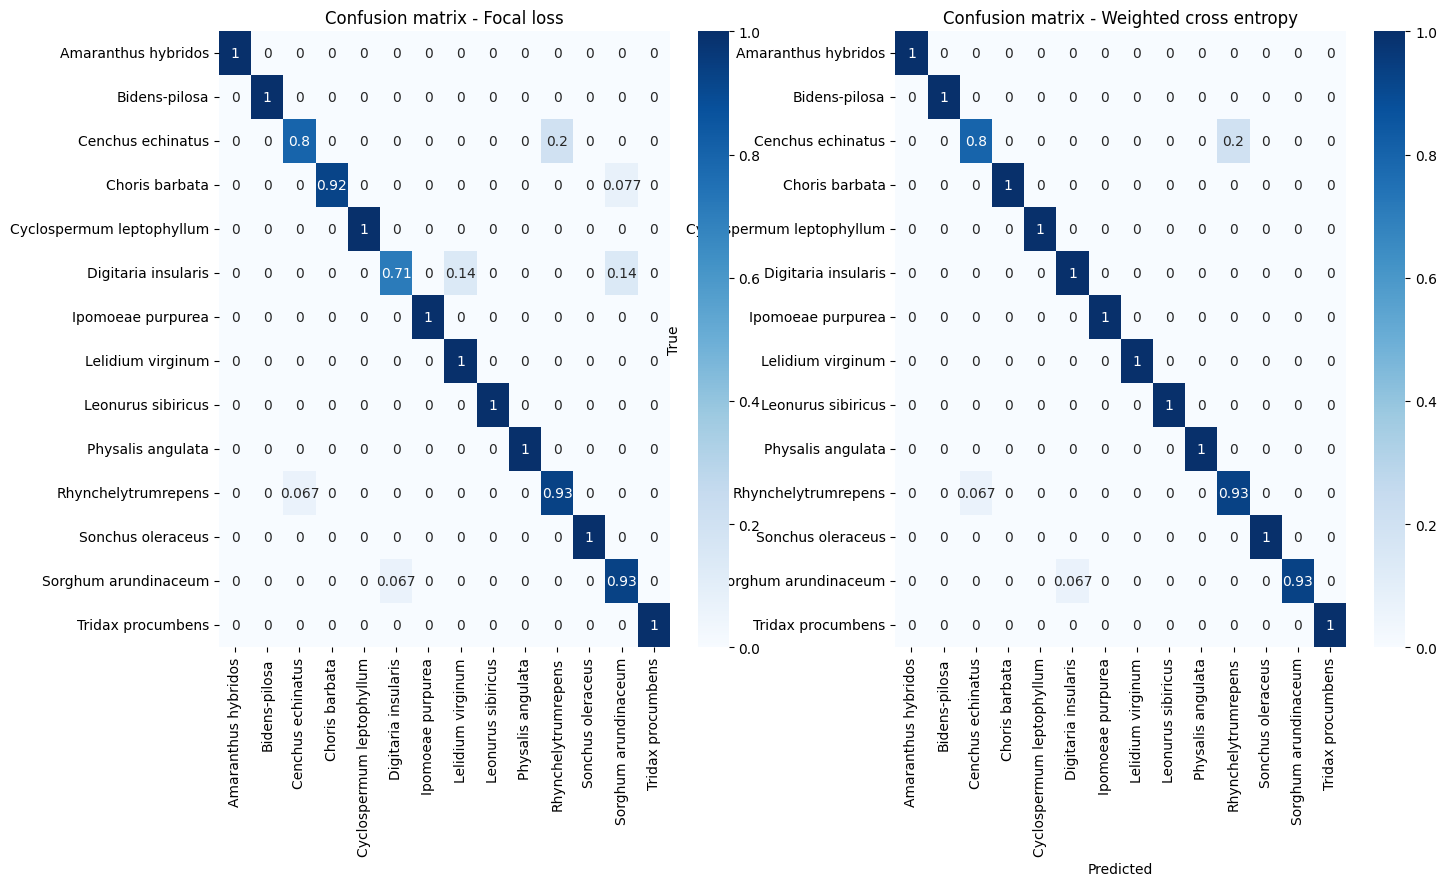

In [14]:
resnet152_model = ResNet152(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
resnet152_model_fc, resnet152_history_fc, resnet152_model_wce, resnet152_history_wce = build_focal_weighted_loss_comparision(resnet152_model, train_ds, val_ds, epochs=epochs)

fig_resnet152, resnet152_fc_report, resnet152_wce_report = generate_fc_wce_comparison(resnet152_model_fc, resnet152_model_wce, test_ds, class_names)
print("General results for focal loss")
print(resnet152_fc_report)

print("General results for WCE")
print(resnet152_wce_report)

### ResNet50

94765736/94765736 [==============================] - 4s 0us/step
Training with focal loss
Epoch 1/20
17/17 [==============================] - 16s 749ms/step - loss: 0.5966 - accuracy: 0.3254 - val_loss: 0.2848 - val_accuracy: 0.5000
Epoch 2/20
17/17 [==============================] - 12s 689ms/step - loss: 0.1975 - accuracy: 0.6213 - val_loss: 0.1891 - val_accuracy: 0.6562
Epoch 3/20
17/17 [==============================] - 12s 689ms/step - loss: 0.1117 - accuracy: 0.7794 - val_loss: 0.1572 - val_accuracy: 0.6875
Epoch 4/20
17/17 [==============================] - 12s 689ms/step - loss: 0.0841 - accuracy: 0.8493 - val_loss: 0.0755 - val_accuracy: 0.8229
Epoch 5/20
17/17 [==============================] - 12s 689ms/step - loss: 0.0490 - accuracy: 0.9265 - val_loss: 0.0602 - val_accuracy: 0.9062
Epoch 6/20
17/17 [==============================] - 12s 690ms/step - loss: 0.0405 - accuracy: 0.9154 - val_loss: 0.0580 - val_accuracy: 0.9167
Epoch 7/20
17/17 [==============================] - 

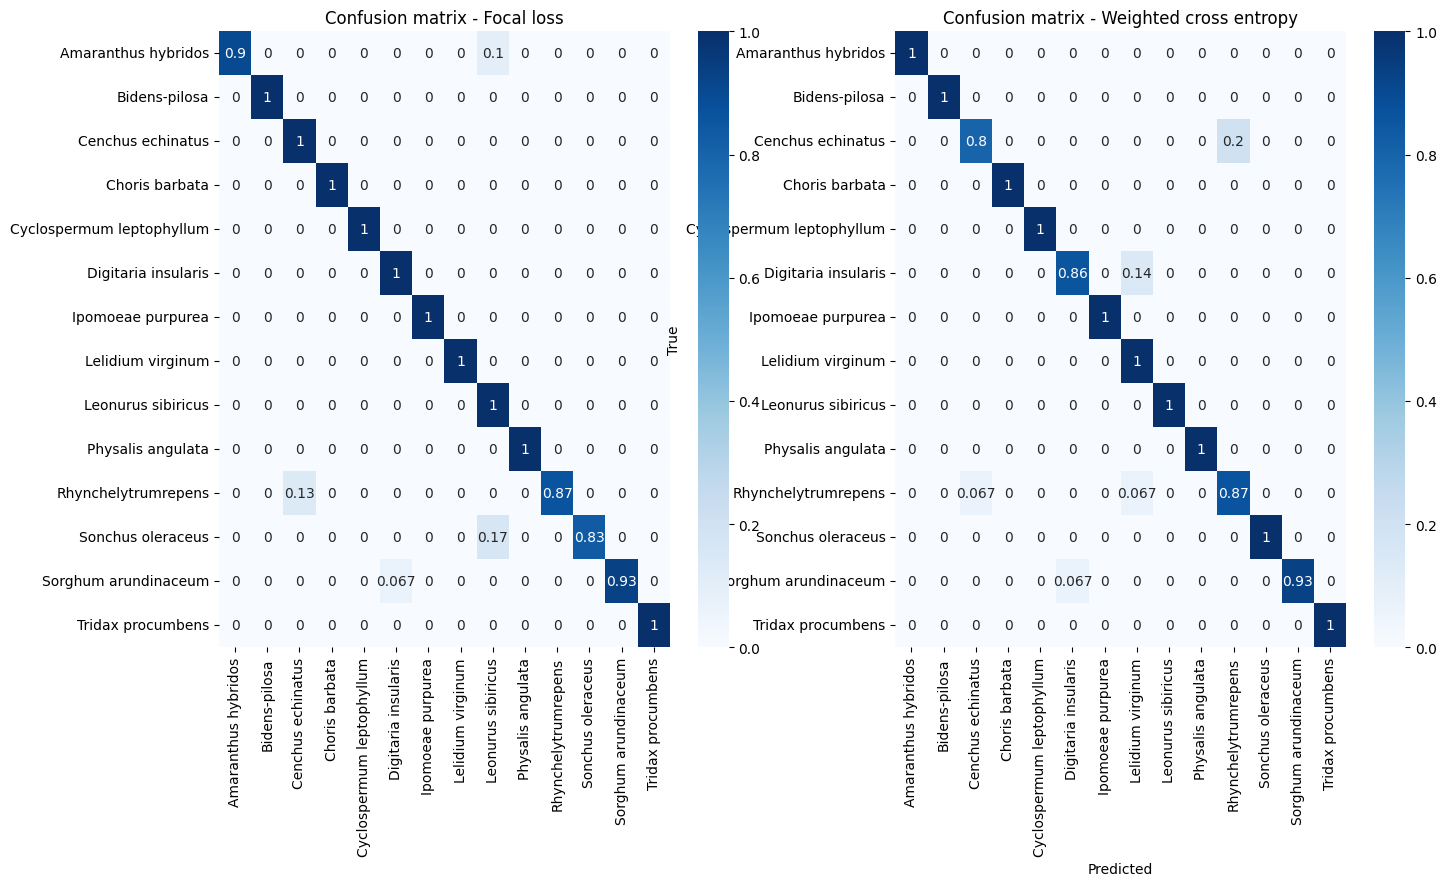

In [15]:
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
resnet50_model_fc, resnet50_history_fc, resnet50_model_wce, resnet50_history_wce = build_focal_weighted_loss_comparision(resnet50_model, train_ds, val_ds, epochs=epochs)

fig_resnet50, resnet50_fc_report, resnet50_wce_report = generate_fc_wce_comparison(resnet50_model_fc, resnet50_model_wce, test_ds, class_names)
print("General results for focal loss")
print(resnet50_fc_report)

print("General results for WCE")
print(resnet50_wce_report)

### Resnet101

171446536/171446536 [==============================] - 7s 0us/step
Training with focal loss
Epoch 1/20
17/17 [==============================] - 26s 1s/step - loss: 0.6766 - accuracy: 0.2849 - val_loss: 0.2885 - val_accuracy: 0.4792
Epoch 2/20
17/17 [==============================] - 18s 1s/step - loss: 0.1999 - accuracy: 0.6158 - val_loss: 0.1444 - val_accuracy: 0.7083
Epoch 3/20
17/17 [==============================] - 18s 1s/step - loss: 0.1089 - accuracy: 0.7923 - val_loss: 0.1164 - val_accuracy: 0.7188
Epoch 4/20
17/17 [==============================] - 18s 1s/step - loss: 0.0798 - accuracy: 0.8438 - val_loss: 0.0787 - val_accuracy: 0.7812
Epoch 5/20
17/17 [==============================] - 18s 1s/step - loss: 0.0643 - accuracy: 0.8750 - val_loss: 0.1046 - val_accuracy: 0.7917
Epoch 6/20
17/17 [==============================] - 18s 1s/step - loss: 0.0472 - accuracy: 0.8915 - val_loss: 0.0513 - val_accuracy: 0.8646
Epoch 7/20
17/17 [==============================] - 18s 1s/step - lo

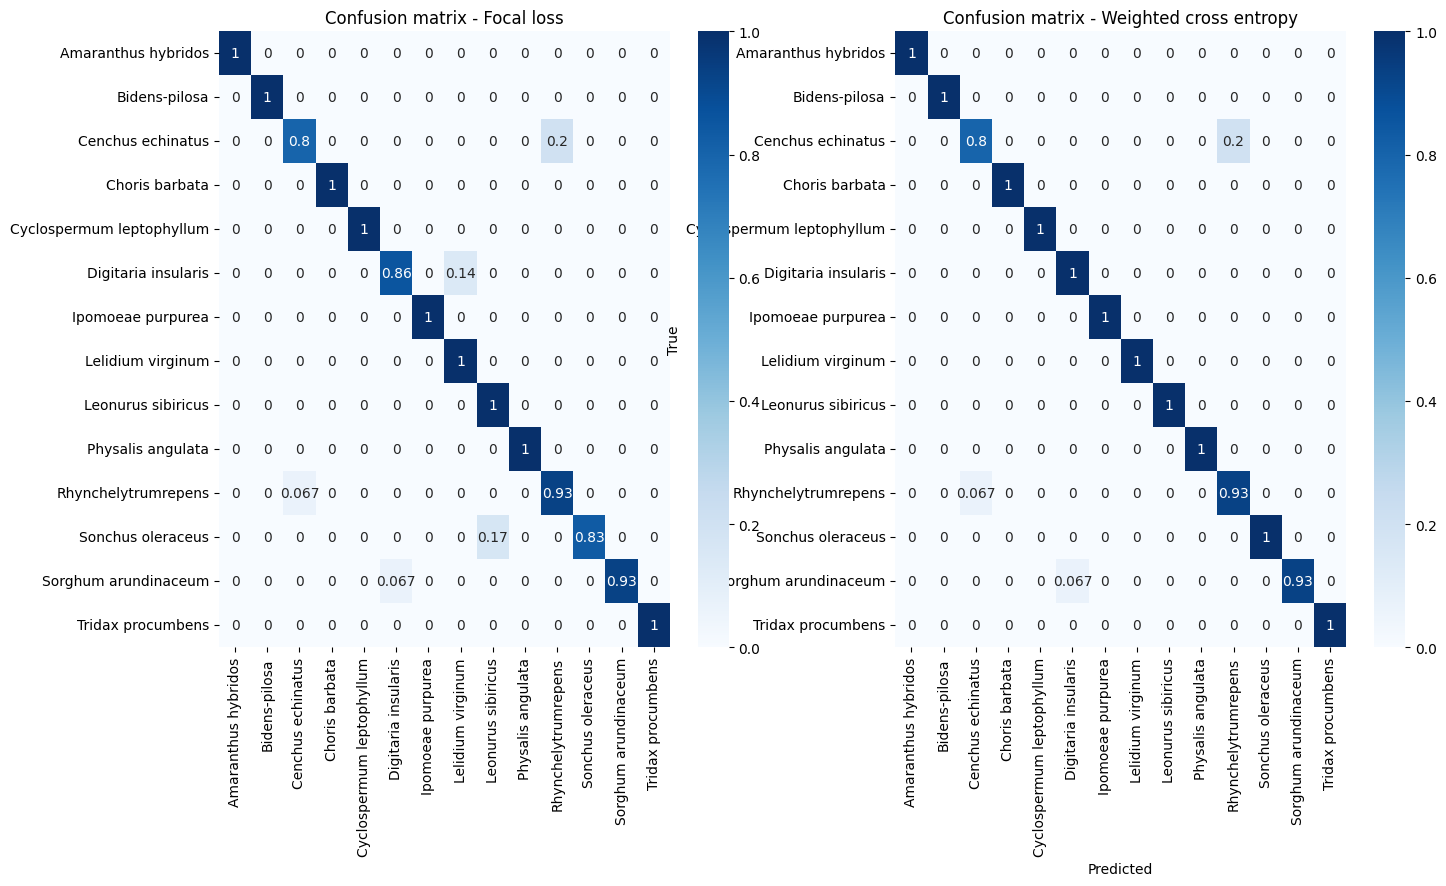

In [16]:
resnet101_model = ResNet101(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
resnet101_model_fc, resnet101_history_fc, resnet101_model_wce, resnet101_history_wce = build_focal_weighted_loss_comparision(resnet101_model, train_ds, val_ds, epochs=epochs)

fig_resnet101, resnet101_fc_report, resnet101_wce_report = generate_fc_wce_comparison(resnet101_model_fc, resnet101_model_wce, test_ds, class_names)
print("General results for focal loss")
print(resnet101_fc_report)

print("General results for WCE")
print(resnet101_wce_report)

### MobileNetV3

12683000/12683000 [==============================] - 1s 0us/step
Training with focal loss
Epoch 1/20
17/17 [==============================] - 13s 416ms/step - loss: 0.4007 - accuracy: 0.3842 - val_loss: 0.1849 - val_accuracy: 0.6354
Epoch 2/20
17/17 [==============================] - 6s 351ms/step - loss: 0.1052 - accuracy: 0.7904 - val_loss: 0.0752 - val_accuracy: 0.8125
Epoch 3/20
17/17 [==============================] - 6s 351ms/step - loss: 0.0486 - accuracy: 0.8952 - val_loss: 0.0519 - val_accuracy: 0.8750
Epoch 4/20
17/17 [==============================] - 6s 351ms/step - loss: 0.0300 - accuracy: 0.9265 - val_loss: 0.0369 - val_accuracy: 0.8854
Epoch 5/20
17/17 [==============================] - 6s 351ms/step - loss: 0.0219 - accuracy: 0.9540 - val_loss: 0.0364 - val_accuracy: 0.8750
Epoch 6/20
17/17 [==============================] - 6s 350ms/step - loss: 0.0153 - accuracy: 0.9688 - val_loss: 0.0213 - val_accuracy: 0.9479
Epoch 7/20
17/17 [==============================] - 6s 35

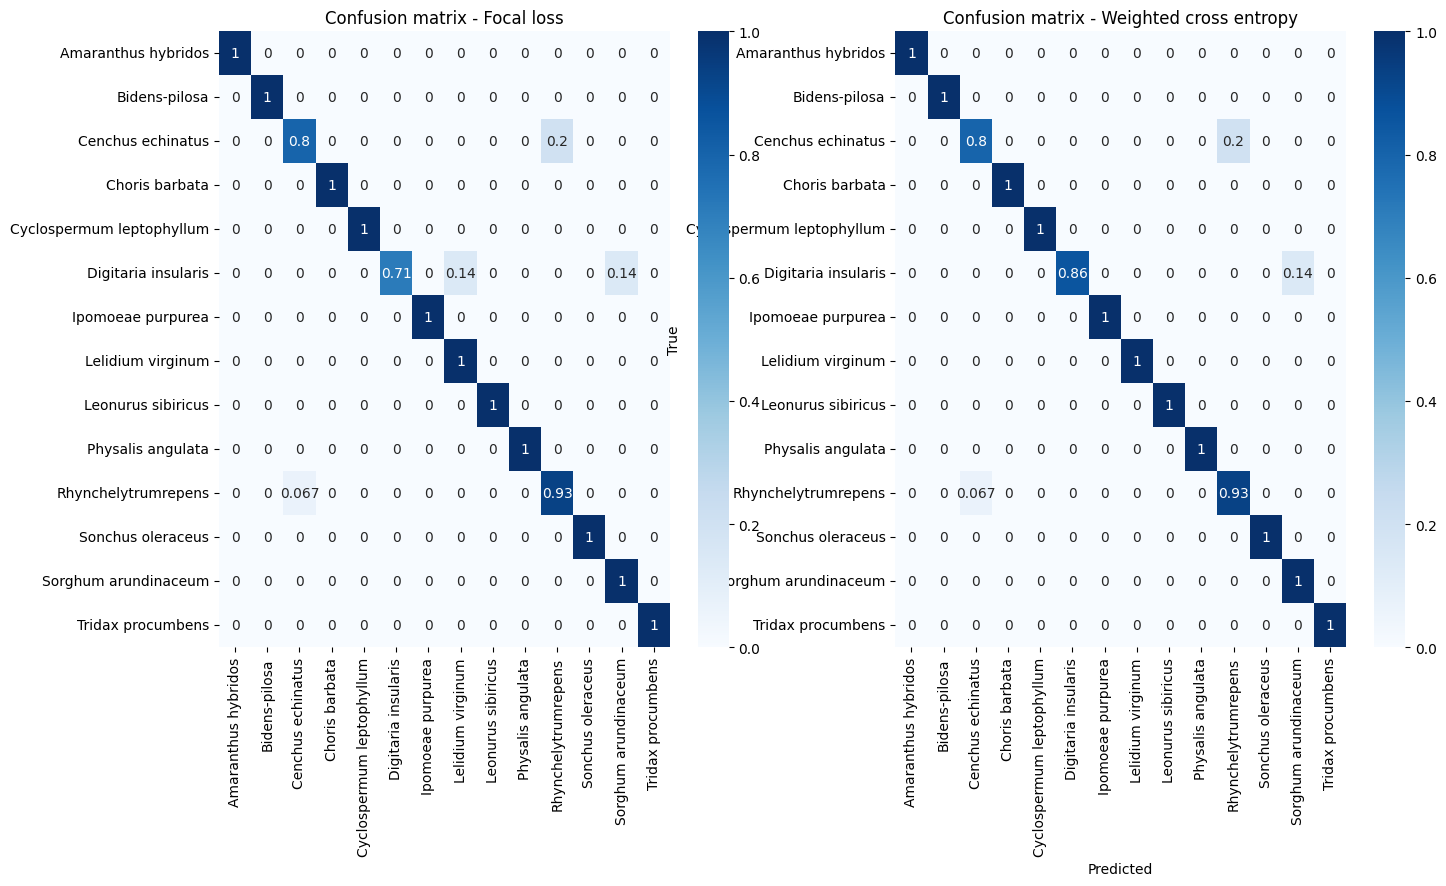

In [17]:
mobile_net_V3_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
mobile_net_V3_model_fc, mobile_net_V3_history_fc, mobile_net_V3_model_wce, mobile_net_V3_history_wce = build_focal_weighted_loss_comparision(mobile_net_V3_model, train_ds, val_ds, epochs=epochs)

fig_mobile_net_V3, mobile_net_V3_fc_report, mobile_net_V3_wce_report = generate_fc_wce_comparison(mobile_net_V3_model_fc, mobile_net_V3_model_wce, test_ds, class_names)
print("General results for focal loss")
print(mobile_net_V3_fc_report)

print("General results for WCE")
print(mobile_net_V3_wce_report)

### MobileNetV2

9406464/9406464 [==============================] - 1s 0us/step
Training with focal loss
Epoch 1/20
17/17 [==============================] - 12s 438ms/step - loss: 0.5748 - accuracy: 0.1452 - val_loss: 0.5100 - val_accuracy: 0.2188
Epoch 2/20
17/17 [==============================] - 7s 388ms/step - loss: 0.4496 - accuracy: 0.2592 - val_loss: 0.4377 - val_accuracy: 0.2292
Epoch 3/20
17/17 [==============================] - 7s 388ms/step - loss: 0.3803 - accuracy: 0.3235 - val_loss: 0.4091 - val_accuracy: 0.3542
Epoch 4/20
17/17 [==============================] - 7s 388ms/step - loss: 0.3403 - accuracy: 0.4191 - val_loss: 0.3706 - val_accuracy: 0.3438
Epoch 5/20
17/17 [==============================] - 7s 388ms/step - loss: 0.2875 - accuracy: 0.4982 - val_loss: 0.3188 - val_accuracy: 0.4583
Epoch 6/20
17/17 [==============================] - 7s 388ms/step - loss: 0.2523 - accuracy: 0.5404 - val_loss: 0.2995 - val_accuracy: 0.5208
Epoch 7/20
17/17 [==============================] - 7s 388m

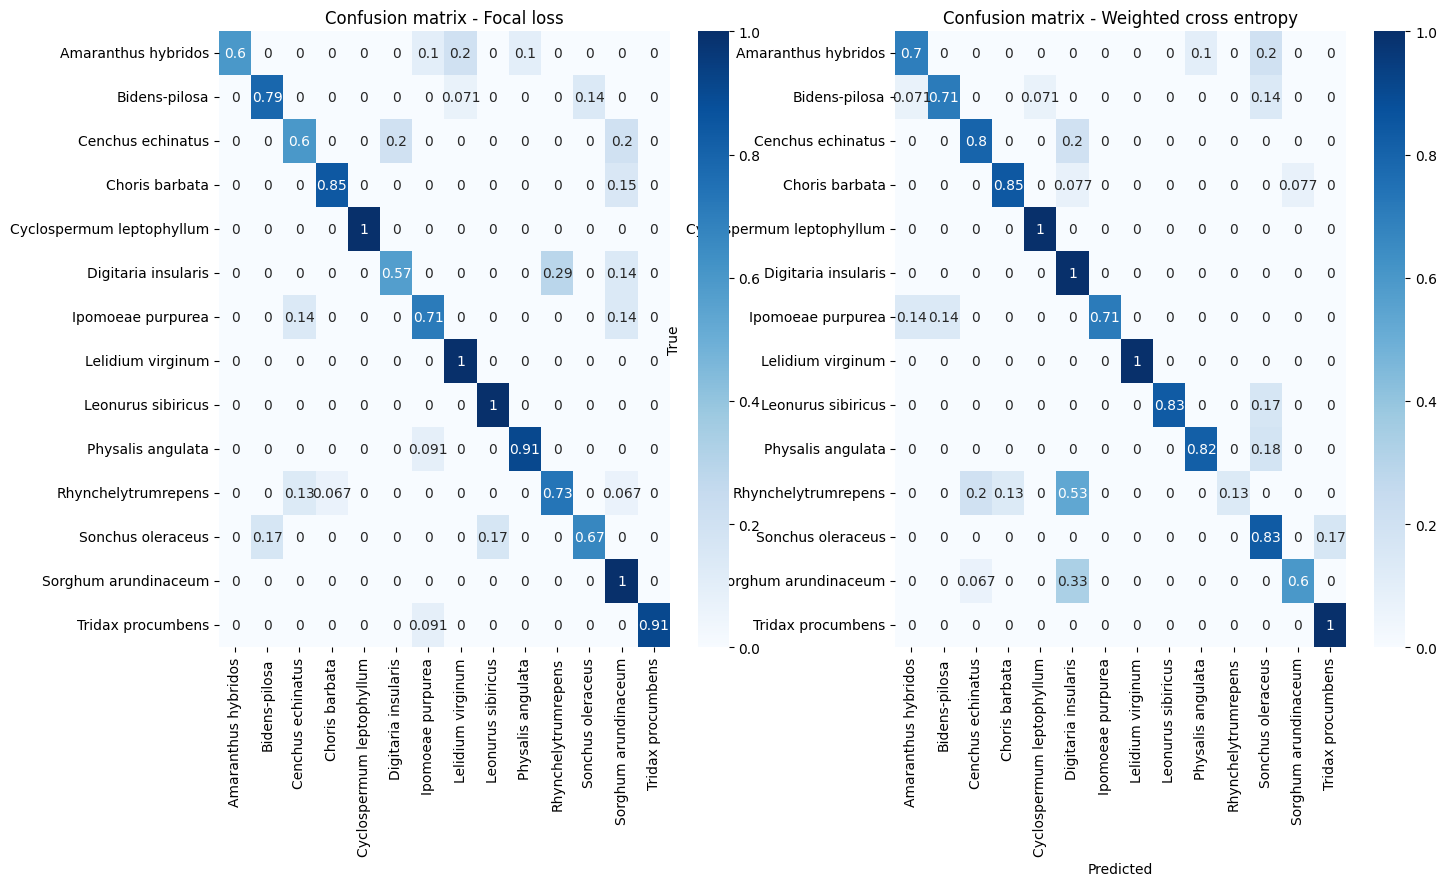

In [18]:
mobile_net_V2_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
mobile_net_V2_model_fc, mobile_net_V2_history_fc, mobile_net_V2_model_wce, mobile_net_V2_history_wce = build_focal_weighted_loss_comparision(mobile_net_V2_model, train_ds, val_ds, epochs=epochs)

fig_mobile_net_V2, mobile_net_V2_fc_report, mobile_net_V2_wce_report = generate_fc_wce_comparison(mobile_net_V2_model_fc, mobile_net_V2_model_wce, test_ds, class_names)
print("General results for focal loss")
print(mobile_net_V2_fc_report)

print("General results for WCE")
print(mobile_net_V2_wce_report)